In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
np.complex = complex

import torch
from torch import nn
from torchvision.transforms import v2 as tfs
import torch.nn.functional as F
from tqdm import tqdm
import librosa
import soundfile as sf
import os
import torchaudio

In [2]:
sns.set(rc={"figure.figsize":(9,6)})

In [3]:
data = pd.read_csv("train.csv")

In [4]:
data.head()

,id,message
0,1.opus,03ЩУЫЛПИГХ
1,2.opus,ЪЛТ0ДС6А3Г
2,3.opus,5ЭКЫБЗХЯН
3,4.opus,ЖЫЦОИ68КФ
4,5.opus,32Ю7МЫ ЗЛ


In [5]:
audio_path = 'morse_dataset/morse_dataset/1.opus'
y, sr = librosa.load(audio_path, sr=8000)

In [6]:
all_text = "".join(data["message"].astype(str).tolist())
unique_chars = sorted(set(all_text))
blank_token = '_'
vocab = [blank_token] + unique_chars
char2idx = {c: i for i, c in enumerate(vocab)}
idx2char = {i: c for c, i in char2idx.items()}

In [7]:
# --- Audio processing & augmentation (from earlier) ---
def extract_mel_spectrogram(
    path,
    sr=8000,
    n_mels=64,
    n_fft=512,
    hop_length=128,
    top_db=30,
    ref_db=40,
    add_noise=False,
    noise_factor=0.005
):
    # Load and trim silence
    y, _ = librosa.load(path, sr=sr)
    y, _ = librosa.effects.trim(y, top_db=top_db)

    # Optional noise augmentation in waveform
    if add_noise:
        noise = noise_factor * np.random.randn(len(y))
        y = y + noise

    # Normalize amplitude
    y = y / (np.max(np.abs(y)) + 1e-6)

    # Mel-spectrogram (power)
    mel = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
    )
    mel_db = librosa.power_to_db(mel, ref=np.max, top_db=ref_db)

    # Convert to tensor, normalize to [-1, 1]
    mel_tensor = torch.from_numpy(mel_db).float()
    mel_min, mel_max = mel_tensor.min(), mel_tensor.max()
    mel_tensor = (mel_tensor - mel_min) / (mel_max - mel_min + 1e-8)  # [0, 1]
    mel_tensor = mel_tensor * 2 - 1  # [-1, 1]
    mel_tensor = mel_tensor.unsqueeze(0)  # [1, n_mels, T]

    return mel_tensor


In [8]:
def crop_mel_band_dynamic(
    mel_tensor,
    energy_threshold=0.95,
    min_band=20,
    max_band=None
):
    """
    Crop frequency bands dynamically: start at peak band and expand until
    cumulative energy in window reaches energy_threshold of total.
    Ensures output band count is between min_band and max_band (if set).
    """
    mel = mel_tensor.squeeze(0)  # [n_mels, T]
    n_mels = mel.shape[0]
    if max_band is None:
        max_band = n_mels

    # Compute energy per band
    energy = mel.pow(2).sum(dim=1)  # [n_mels]
    total_energy = energy.sum()
    peak = int(torch.argmax(energy).item())

    start = peak
    end = peak
    window_energy = energy[peak]
    # Expand window until enough energy captured or limits reached
    while window_energy < energy_threshold * total_energy and (start > 0 or end < n_mels - 1):
        low_energy = energy[start - 1] if start > 0 else torch.tensor(-1.)
        high_energy = energy[end + 1] if end < n_mels - 1 else torch.tensor(-1.)
        if low_energy > high_energy:
            start -= 1
            window_energy += low_energy
        else:
            end += 1
            window_energy += high_energy
        # stop if window too large
        if (end - start + 1) >= max_band:
            break

    # enforce minimum band size
    if (end - start + 1) < min_band:
        half = min_band // 2
        start = max(0, peak - half)
        end = min(n_mels, start + min_band)

    # enforce maximum band size
    if (end - start + 1) > max_band:
        end = start + max_band

    cropped = mel[start:end, :]  # [band, T]
    return cropped.unsqueeze(0)

In [9]:

def apply_spec_augment(
    mel_tensor,
    time_mask_param=30,
    freq_mask_param=10,
    num_time_masks=2,
    num_freq_masks=2
):
    """
    Apply SpecAugment: random time and frequency masking on mel-spectrogram.
    """
    aug = mel_tensor.clone()
    for _ in range(num_freq_masks):
        aug = torchaudio.transforms.FrequencyMasking(freq_mask_param)(aug)
    for _ in range(num_time_masks):
        aug = torchaudio.transforms.TimeMasking(time_mask_param)(aug)
    return aug

In [10]:
def show_melspect(mel_tensor, sr=8000, hop_length=128):
    """Display mel-spectrogram. Accepts torch.Tensor or numpy array of shape [1,n_mels,T] or [n_mels,T]."""
    import matplotlib.pyplot as plt
    import librosa.display
    import numpy as np
    import torch

    # Convert to numpy
    if isinstance(mel_tensor, torch.Tensor):
        arr = mel_tensor.detach().cpu().numpy()
    else:
        arr = np.array(mel_tensor)

    # Squeeze batch dimension if present
    if arr.ndim == 3 and arr.shape[0] == 1:
        arr = arr.squeeze(0)
    elif arr.ndim != 2:
        raise ValueError(f"Unsupported spectrogram shape: {arr.shape}")

    # If values in [-1,1], map to [0,1] for display
    if arr.min() >= -1 and arr.max() <= 1:
        disp = (arr + 1) / 2
    else:
        disp = arr

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(disp, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f')
    plt.title('Mel-spectrogram')
    plt.tight_layout()
    plt.show()

Mel-spectrogram time: 0.138s
torch.Size([1, 60, 501])


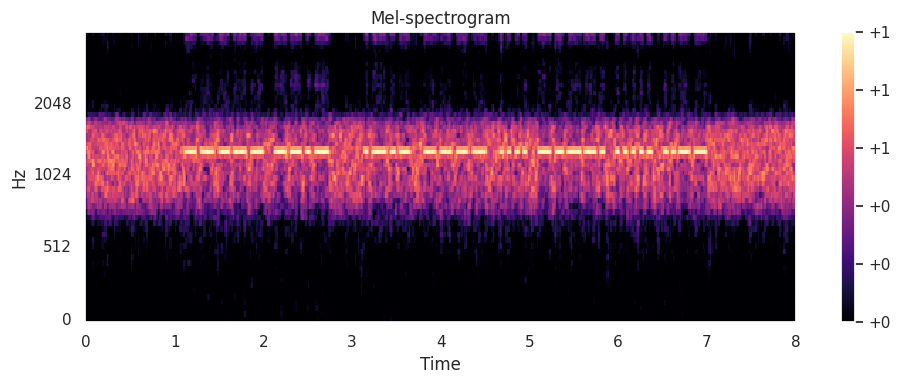

In [11]:
import time
start = time.time()

spec = extract_mel_spectrogram("morse_dataset/morse_dataset/1488.opus")
spec_croped = crop_mel_band_dynamic(spec)
print(f"Mel-spectrogram time: {time.time() - start:.3f}s")
print(spec_croped.shape)
show_melspect(spec_croped.squeeze(0).numpy())

In [12]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence


class MorseDataset(Dataset):
    def __init__(
        self,
        csv_path,
        audio_dir,
        target_height=32,
        add_noise=False,
        noise_factor=0.005,
        spec_augment=False,
        time_mask_param=30,
        freq_mask_param=10,
        num_time_masks=2,
        num_freq_masks=2
    ):
        if csv_path is not None:
            self.df = pd.read_csv(csv_path)
        self.audio_dir = audio_dir
        self.target_height = target_height
        self.add_noise = add_noise
        self.noise_factor = noise_factor
        self.spec_augment = spec_augment
        self.time_mask_param = time_mask_param
        self.freq_mask_param = freq_mask_param
        self.num_time_masks = num_time_masks
        self.num_freq_masks = num_freq_masks

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        fname = row["id"]
        text = row["message"]
        path = os.path.join(self.audio_dir, fname)

        # extract mel-spectrogram
        spec = extract_mel_spectrogram(
            path,
            add_noise=self.add_noise,
            noise_factor=self.noise_factor
        )  # [1, n_mels, T]

        # dynamic frequency cropping with fixed height
        spec = crop_mel_band_dynamic(
            spec,
            min_band=self.target_height,
            max_band=self.target_height
        )

        # SpecAugment on spectrogram
        if self.spec_augment:
            spec = apply_spec_augment(
                spec,
                time_mask_param=self.time_mask_param,
                freq_mask_param=self.freq_mask_param,
                num_time_masks=self.num_time_masks,
                num_freq_masks=self.num_freq_masks
            )

        # encode target text to indices
        target = torch.tensor([char2idx[c] for c in text], dtype=torch.long)

        return spec, target


In [13]:

def collate_fn(batch):
    specs, targets = zip(*batch)
    spec_lens = torch.tensor([s.shape[-1] for s in specs], dtype=torch.long)

    # pad spectrograms along time dimension
    specs_seq = [s.squeeze(0).transpose(0,1) for s in specs]
    specs_padded = pad_sequence(specs_seq, batch_first=True)
    specs_padded = specs_padded.transpose(1,2).unsqueeze(1)

    target_lens = torch.tensor([t.numel() for t in targets], dtype=torch.long)
    targets_concat = torch.cat(targets)

    return specs_padded, spec_lens, targets_concat, target_lens

In [14]:
# Utility to visualize activations after CNN layers
def plot_activations(x, layer_name):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    # sum across channel dimension
    activation_map = x[0].detach().sum(dim=0).cpu()
    plt.imshow(activation_map, aspect='auto', cmap='viridis')
    plt.title(f"Активации: {layer_name}")
    plt.colorbar()
    plt.tight_layout()
    plt.show()

In [15]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    """ResNet-style блок: Conv → BN → ELU → Conv → BN → ELU + Skip"""
    def __init__(self, in_ch, out_ch, stride=(1,1)):
        super().__init__()
        self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, stride=stride)
        self.bn1   = nn.BatchNorm2d(out_ch)
        self.elu1  = nn.ELU()
        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)
        self.elu2  = nn.ELU()
        # если меняются каналы или страйд, делаем проекцию
        if stride != (1,1) or in_ch != out_ch:
            self.proj = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_ch)
            )
        else:
            self.proj = None

    def forward(self, x):
        identity = x
        out = self.elu1(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.proj:
            identity = self.proj(identity)
        out = self.elu2(out + identity)
        return out

class MorseCTCModel(nn.Module):
    def __init__(
        self,
        n_mels: int = 32,
        n_classes: int = None,   # len(vocab)
        cnn_channels: list = [32, 64, 128],
        lstm_hidden: int = 256,
        lstm_layers: int = 2,
        dropout: float = 0.3
    ):
        super().__init__()
        assert n_classes is not None, "Укажите размер словаря"
        # 1) CNN backbone
        layers = []
        in_ch = 1
        for ch in cnn_channels:
            # делаем пулинг только по частоте, stride=(2,1)
            layers.append(ConvBlock(in_ch, ch, stride=(2,1)))
            in_ch = ch
        self.cnn = nn.Sequential(*layers)
        # после CNN: частоты уменьшились в ratio 2^len(cnn_channels), время не тронуто

        # 2) нормализация карты признаков
        self.layer_norm = nn.LayerNorm(cnn_channels[-1])

        # 3) LSTM encoder
        self.lstm = nn.LSTM(
            input_size = cnn_channels[-1],  # каждый timestep получаем суммированную по freq фичу
            hidden_size = lstm_hidden,
            num_layers  = lstm_layers,
            batch_first = True,
            bidirectional = True,
            dropout = dropout if lstm_layers > 1 else 0.0
        )

        # 4) классификатор под CTC
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(2 * lstm_hidden, n_classes)
        )

    def forward(self, x, lengths=None):
        """
        x: [B, 1, n_mels, T]
        lengths: оригинальные длины T (до CNN)
        """
        B, _, _, T = x.size()
        # --- CNN ---
        x = self.cnn(x)  # [B, C, n_mels//2^k, T]
        # Сжимаем частотную ось (GlobalAvgPool по высоте)
        x = x.mean(dim=2)  # [B, C, T]
        # Переставляем для LSTM
        x = x.permute(0, 2, 1)  # [B, T, C]
        # LayerNorm по фичам
        x = self.layer_norm(x)

        # --- LSTM ---
        # lengths нужно скорректировать: делим на 2^len(cnn_channels) и округляем вниз
        if lengths is not None:
            down = 2 ** len(self.cnn)
            input_lengths = (lengths.float() / down).floor().long()
        else:
            input_lengths = None

        # упаковываем, если заданы lengths
        if input_lengths is not None:
            x_packed = nn.utils.rnn.pack_padded_sequence(
                x, input_lengths.cpu(), batch_first=True, enforce_sorted=False
            )
            out_packed, _ = self.lstm(x_packed)
            out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        else:
            out, _ = self.lstm(x)

        # --- Classifier ---
        logits = self.classifier(out)  # [B, T', n_classes]
        # возвращаем логи и скорректированные длины
        return logits, input_lengths


In [16]:
class LightMorseCTCModel(nn.Module):
    """
    Упрощённая версия модели для ускоренного обучения:
      - Меньше каналов в CNN
      - Однослойный LSTM
      - Меньший hidden state
    """
    def __init__(
        self,
        n_mels: int = 32,
        n_classes: int = None,
        cnn_channels: list = [16, 32],
        lstm_hidden: int = 128,
        lstm_layers: int = 1,
        dropout: float = 0.2
    ):
        super().__init__()
        assert n_classes is not None, "Укажите размер словаря"
        # CNN backbone
        layers = []
        in_ch = 1
        for ch in cnn_channels:
            layers.append(
                nn.Sequential(
                    nn.Conv2d(in_ch, ch, kernel_size=3, padding=1, stride=(2,1)),
                    nn.BatchNorm2d(ch),
                    nn.ELU()
                )
            )
            in_ch = ch
        self.cnn = nn.Sequential(*layers)
        # LayerNorm по фичам
        self.layer_norm = nn.LayerNorm(cnn_channels[-1])
        # LSTM encoder
        self.lstm = nn.LSTM(
            input_size=cnn_channels[-1],
            hidden_size=lstm_hidden,
            num_layers=lstm_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if lstm_layers>1 else 0.0
        )
        # Классификатор
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(2*lstm_hidden, n_classes)
        )

    def forward(self, x, lengths=None):
        B, _, _, T = x.size()
        x = self.cnn(x)         # [B,C, n_mels/2^k, T]
        x = x.mean(dim=2)       # [B,C,T]
        x = x.permute(0,2,1)    # [B,T,C]
        x = self.layer_norm(x)
        # adjust lengths
        if lengths is not None:
            down = 2**len(self.cnn)
            input_lengths = (lengths.float()/down).floor().long()
        else:
            input_lengths = None
        # LSTM
        if input_lengths is not None:
            packed = nn.utils.rnn.pack_padded_sequence(x, input_lengths.cpu(), batch_first=True, enforce_sorted=False)
            out_packed, _ = self.lstm(packed)
            out, _ = nn.utils.rnn.pad_packed_sequence(out_packed, batch_first=True)
        else:
            out, _ = self.lstm(x)
        logits = self.classifier(out)
        return logits, input_lengths

In [17]:
import sklearn.model_selection as skms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
full_df = pd.read_csv('train.csv')
train_idx, val_idx = skms.train_test_split(
    full_df.index,
    test_size=0.1,
    random_state=42,
    shuffle=True
)
train_df = full_df.loc[train_idx].reset_index(drop=True)
val_df   = full_df.loc[val_idx].reset_index(drop=True)

# Create datasets using DataFrame subsets
train_ds = MorseDataset(
    csv_path=None,
    audio_dir='morse_dataset/morse_dataset/',
    target_height=32,
    add_noise=True,
    spec_augment=True
)
# Override internal DataFrame
train_ds.df = train_df

val_ds = MorseDataset(
    csv_path=None,
    audio_dir='morse_dataset/morse_dataset/',
    target_height=32,
    add_noise=False,
    spec_augment=False
)
val_ds.df = val_df

# DataLoaders
train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)
val_loader = DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

In [18]:
# Initialize model, optimizer, loss
model = MorseCTCModel(
    n_mels=32,
    n_classes=len(vocab)
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)

ctc_loss = nn.CTCLoss(blank=char2idx[blank_token], zero_infinity=True)

In [ ]:
# Training loop

num_epochs = 20
for epoch in range(1, num_epochs+1):
    model.train()
    running_loss = 0.0
    loss_mean = 0.0
    lm_count = 0
    train_loader_tqdm = tqdm(train_loader, leave=True)
    for specs, spec_lens, targets_concat, target_lens in train_loader_tqdm:
        specs, targets_concat = specs.to(device), targets_concat.to(device)
        optimizer.zero_grad()
        logits, input_lens = model(specs, spec_lens)
        log_probs = logits.log_softmax(2).transpose(0,1)
        loss = ctc_loss(log_probs, targets_concat, input_lens, target_lens)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()

        lm_count +=1
        running_loss += loss.item() * specs.size(0)
        loss_mean = 1/lm_count * loss.item() + (1 - 1/lm_count) * loss_mean
        train_loader_tqdm.set_description(f"Epoch [{epoch}/{num_epochs}], loss_mean={loss_mean:.3f}")

    epoch_loss = running_loss / len(train_ds)

    # Validation
    model.eval()
    val_loss = 0.0
    vloss_mean = 0.0
    vlm_count = 0
    val_loader_tqdm = tqdm(val_loader, leave=True)
    with torch.no_grad():
        for specs, spec_lens, targets_concat, target_lens in val_loader_tqdm:
            specs, targets_concat = specs.to(device), targets_concat.to(device)
            logits, input_lens = model(specs, spec_lens)
            log_probs = logits.log_softmax(2).transpose(0,1)
            loss = ctc_loss(log_probs, targets_concat, input_lens, target_lens)
            val_loss += loss.item() * specs.size(0)
            vlm_count +=1
            vloss_mean = 1/vlm_count * loss.item() + (1 - 1/vlm_count) * vloss_mean
            val_loader_tqdm.set_description(f"Epoch [{epoch}/{num_epochs}], loss_mean={vloss_mean:.3f}")
    val_loss /= len(val_ds)
    scheduler.step(val_loss)

    print(f'Epoch {epoch}/{num_epochs} - Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}')

# Test-pass: decode a batch from validation
model.eval()
specs, spec_lens, _, _ = next(iter(val_loader))
specs = specs.to(device)
logits, input_lens = model(specs, spec_lens)
preds = logits.argmax(dim=-1)
for i in range(3):
    seq = preds[i, :input_lens[i]].cpu().tolist()
    decoded = ''.join(idx2char[idx] for idx in seq if idx != char2idx[blank_token])
    print(f'Sample {i}: "{decoded}"')

Epoch [1/20], loss_mean=4.247:  46%|████▌     | 386/844 [15:24<16:31,  2.16s/it]

In [ ]:
def ctc_greedy_decode(logits, input_lens, idx2char, blank_idx):
    """
    logits: тензор [B, T, C]
    input_lens: длины T’ для каждого примера
    """
    preds = logits.argmax(dim=-1)  # [B, T]
    results = []
    for b in range(preds.size(0)):
        seq = preds[b, :input_lens[b]].cpu().tolist()
        decoded = []
        prev = None
        for idx in seq:
            if idx != prev and idx != blank_idx:
                decoded.append(idx2char[idx])
            prev = idx
        results.append(''.join(decoded))
    return results

# Пример использования:
decoded_samples = ctc_greedy_decode(logits, input_lens, idx2char, char2idx[blank_token])
for i, txt in enumerate(decoded_samples[:3]):
    print(f"Sample {i}: '{txt}'")